## **Workshop: A Quantum Engineer's Guide to the Quantum Optimal Control Suite (QuOCS)**

#### **by Ressa Said and Hendry Lim**

---

### **To begin**

Let us begin by installing and importing everything we need:

- [NumPy](numpy.org) is the bread and butter of numerical simulations in Python.

- [QuOCS](https://github.com/Quantum-OCS/QuOCS), of course.

- [QuTiP](qutip.org) is a convenient tool to numerically simulate quantum system dynamics with the exact diagonalization method. We will need this to avoid having to rewrite the code to simulate the evolution of our physical systems.

- [Matplotlib](matplotlib.org) is useful for plotting our results.

To install them using `pip`, run the following in your system terminal,

```
pip install numpy quocs-lib qutip matplotlib
```

We can now import these packages. We also import the built-in modules `os` and `shutil` to deal with I/O, as well as `typing` to make the code look prettier in IDEs.

In [1]:
import qutip as qt
import numpy as np
import os
import shutil
import typing

from quocslib.Optimizer import Optimizer
from quocslib.utils.AbstractFoM import AbstractFoM

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2


---

### **The control landscape**

We start by specifying the control problem and building the control landscape.

**System dynamics**

One exemplary problem for quantum optimal control is the **Ising ring**. Let us consider only the interaction between nearest neighbors with a single control applied to all the qubits. Mathematically, the Hamiltonian is given by
$$
\hat{H} = -J \sum_{k=0}^{N-1} \hat{\sigma}^z_k \hat{\sigma}^z_{k+1}+ u(t)\cdot\sum_{k=0}^{N-1}\hat{\sigma}^x_{k}; \qquad \hat{\sigma}^z_{N-1} = \hat{\sigma}^z_0
$$

**Cost function&mdash;the metric of success to minimize**

Let all the qubits start in the ground state,
$$
\left|\psi_i \right\rangle = \bigotimes\limits_{k=0}^{N-1} \left|0\right\rangle_k
$$
Our **goal** is to apply a control to get them all into the excited state,
$$
\left|\psi_\mathrm{target} \right\rangle = \bigotimes\limits_{k=0}^{N-1} \left|1\right\rangle_k
$$
i.e. we want to optimize the system's **state-to-state transfer**.

We can measure how "close" the post-control final system state $\left|\psi_f\right\rangle$ is to our target, using quantum state measures such as fidelity and trace distance. Here we shall use the state infidelity
$$
J = 1 - F\left(\left|\psi_f\right\rangle,\left|\psi_\mathrm{target}\right\rangle\right) 
$$
as the cost function, with the fidelity defined as in Nielsen and Chuang,
$$
F\left(\left|\phi\right\rangle,\left|\psi\right\rangle\right) = \left|\left\langle\phi\middle|\psi\right\rangle\right|
$$
The value of $J$ is $1$ if $\rho$ and $\sigma$ are orthogonal, and $0$ if they are indistinguishable.

**Control space restriction**

Let us keep the pulse amplitude from going over $10\ \mathrm{a.u.}$,
$$
\left|u(t)\right| \leq 10
$$

---

### **Setup**

In [3]:
TIME_STEPS = 501
PULSE_DURATION = 1
MAX_AMPLITUDE = 10
N_QUBIT = 3
J = 1


---

### **Optimization settings**

Here's a fun little challenge for you: 
-   Set `algorithm_settings["max_eval_total"] = 5000`.
-   Set `algorithm_settings["FoM_goal"] = 1e-6`.
-   Set other options to your liking.
-   Run the optimization later and see how low your cost function gets by the end of the optimization. Better yet, see if you can get to the goal value of $10^{-6}$ with less than $5000$ total iterations.

With the default setting, the optimized cost-function value is $0.00265556135230538$ with $5000$ iterations used up.

In [13]:
dsm_settings = {
    "general_settings" : {"dsm_algorithm_name" : "NelderMead", # ["NelderMead", "CMAES"]
                          "is_adaptive" : True}, # for NM only
    
    "stopping_criteria" : {"max_eval" : 100000000, # before moving to the next superiteration.
                           "time_lim" : 3600,
                           "xatol" : 1e-14,
                           "fatol" : 1e-100,
                           "change_based_stop" : {"cbs_change" : 1e-5,
                                                  "cbs_funct_evals" : 500}}
}

algorithm_settings = {
    "algorithm_name" : "dCRAB", # one of ["dCRAB", "GRAPE", "AD", "DirectSearch"]
    "optimization_direction" : "minimization", # for cost function, or "maximization" for Figure of Merit (FoM).
    "super_iteration_number" : 1000000,
    "max_eval_total" : 5000, # before stopping the optimization run.
    "FoM_goal" : 1e-6,
    
    "random_number_generator" : {"seed_number" : 12345}, # for reproducibility
    
    "dsm_settings" : dsm_settings
    }

###

initial_guess = "lambda t : np.sin(t)"
scaling_function = "lambda t : np.tanh(30*np.sin(np.pi*t/2))*np.tanh(-30*np.sin(np.pi/2*(t-1)))"
pulses = [
    {"pulse_name" : "control",
     "upper_limit" : MAX_AMPLITUDE,
     "lower_limit" : -MAX_AMPLITUDE,
     "bins_number" : TIME_STEPS,
     "time_name" : "time",  # must match opt_dict["times"]["time_name"]
     "amplitude_variation" : 0.5, # keep smaller than the amplitude range.
     "shrink_ampl_lim" : True, # if False, pulse is cut off at the limit. 
     
     "basis" : {"basis_name" : "Fourier", # one of ["Fourier", "Chebyshev", "Sinc", "Sigmoid", ]
                "basis_vector_number" : 5,
                
                # For the information on the basis vector and super parameter, see 
                # https://github.com/Quantum-OCS/QuOCS/blob/develop/Documentation/Settings_in_Optimization_Dict.md#bases-overview
                # (note that the correct basis name is "Chebyshev" and not "Chebychev" as is currently written there.)
                
                "random_super_parameter_distribution" : {"distribution_name" : "Uniform", # no other choice in current version.
                                                         "lower_limit" : 0,
                                                         "upper_limit" : 10}
                },
     
     "initial_guess" : {"function_type" : "list_function",  # ["list_function", "lambda_function"]
                        "list_function" : np.zeros(shape=(TIME_STEPS,)), # recommended
                        "lambda_function" : initial_guess   # very, very, very not pythonic since the `eval` function is used
                        },
     
     "scaling_function" : {"function_type" : "lambda_function",
                           "list_function" : np.ones(shape=(TIME_STEPS,)),
                           "lambda_function" : scaling_function}
     }
]

###

parameters = [
    {"parameter_name" : "param_1",
     "lower_limit" : 0,
     "upper_limit" : 1,
     "initial_value" : 0,
     "amplitude_variation" : 0.05}
] # unused in this example.
parameters = []

###

times = [
    {"time_name" : "time",
     "initial_value" : PULSE_DURATION}
]

###

opt_dict = {
    "optimization_client_name" : "meow",
    "create_logfile" : False,
    "console_info" : True,
    "dump_format" : "npz", # either "npz" or "json"
    "algorithm_settings" : algorithm_settings,
    "pulses" : pulses,
    "parameters" : parameters,
    "times" : times
    }


---

### **Plotting the initial guess and scaling function**

Text(0, 0.5, 'scaling function')

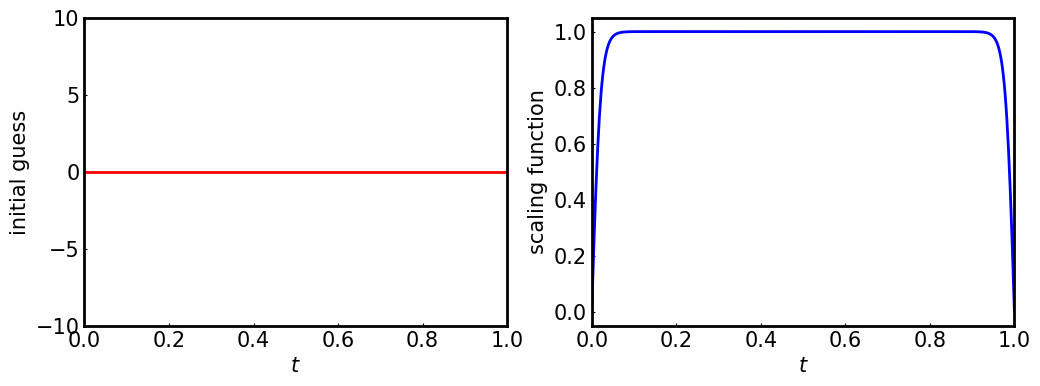

In [5]:
tlist = np.linspace(0, PULSE_DURATION, TIME_STEPS)

if opt_dict["pulses"][0]["initial_guess"]["function_type"] == "lambda_function":
    init_guess = eval(opt_dict["pulses"][0]["initial_guess"]["lambda_function"])(tlist)
else:
    init_guess = opt_dict["pulses"][0]["initial_guess"]["list_function"]

if opt_dict["pulses"][0]["scaling_function"]["function_type"] == "lambda_function":
    scaling_foo = eval(opt_dict["pulses"][0]["scaling_function"]["lambda_function"])(tlist)
else:
    scaling_foo = opt_dict["pulses"][0]["scaling_function"]["list_function"]

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs : typing.List[plt.Axes]
ax = axs[0]
ax.plot(tlist, init_guess, c = "r")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(opt_dict["pulses"][0]["lower_limit"],
            opt_dict["pulses"][0]["upper_limit"])
ax.set_xlabel(r"$t$")
ax.set_ylabel("initial guess")

ax = axs[1]
ax.plot(tlist, scaling_foo, c = "b")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_xlabel(r"$t$")
ax.set_ylabel("scaling function")


---

### **Specifying the cost function**

The following code block takes the `control` array (which will be supplied by QuOCS throughout the optimization run) as an input and outputs the cost function, i.e. the trace distance between the final state and the target state. The system's evolution under the given `control` is conveniently computed with QuTiP. You need not understand its workflow (our concern is the QOC part, after all)&mdash;just keep in mind what it takes as an input and what it outputs. 

In [6]:
def treat_control(control, tlist):
    def check_len():
        if len(control) != len(tlist):
            raise ValueError("Mismatched pulse and time bins.")
    
    if isinstance(control, np.ndarray):
        check_len()
        return control
    elif isinstance(control, list):
        check_len()
        return np.array(control)
    elif callable(control):
        return control(tlist)
    else:
        return np.array([control]*len(tlist))

sx = qt.sigmax()
sz = qt.sigmaz()
H_template = []
for i in range(N_QUBIT):
    ops = [qt.qeye(2)]*N_QUBIT
    ops_next = [qt.qeye(2)]*N_QUBIT
    
    ops[i] = sz
    if i == (N_QUBIT-1):
        ops_next[0] = sz
    else:
        ops_next[i+1] = sz
        
    sz_i = qt.tensor(*ops)
    sz_i_plus_1 = qt.tensor(*ops_next)
        
    H_template.append(-J*sz_i*sz_i_plus_1)
    
    ops[i] = sx
    sx_i = qt.tensor(*ops)
    
    H_template.append([sx_i, None])
    
def get_Ising_H(control):
    for i in range(N_QUBIT):
        H_template[2*i+1][1] = control
        
    return H_template
    
def get_cost_function(control,
                      plot_bloch = False):
    """
    control : numpy.ndarray
        The test control obtained in the given QOC iteration.
        
    plot_bloch : bool, default: False
        Whether to plot the Bloch sphere representation of the first-qubit partial-trace.
    """

    psi0 = qt.tensor(*[qt.basis(2, 0)]*3)
    psi_target = qt.tensor(*[qt.basis(2,1)]*3)
    
    tlist = np.linspace(0, PULSE_DURATION, TIME_STEPS)
    control = treat_control(control, tlist)
    
    H = get_Ising_H(control)
    
    rho_t = qt.mesolve(H = H,
                       tlist = tlist,
                       rho0 = psi0).states
    
    cf = 1 - qt.fidelity(rho_t[-1], psi_target)

    if plot_bloch:
        rho_0_t = []
        for i in range(len(tlist)):
            rho_0_t.append(qt.ptrace(rho_t[i], 0))
        b = qt.Bloch()
        b.add_annotation(qt.basis(2,1)*1.2, 
                         r"$J=%s$" % "%.6f" % cf)
        b.add_states(rho_0_t[1:-1], kind = "point", colors = ["b"]*(TIME_STEPS-2), alpha = 0.1)
        b.add_states(rho_0_t[0])
        b.add_states(rho_0_t[-1])
        b.show()
        
    return cf

Having written the quantum description and function that outputs the cost function, we can now make the cost function object used in QuOCS. The package requires us to inherit the `AbstractFoM` class and set the `get_FoM` method to return the figure of merit in the form of a dictionary `{"FoM" : FoM_value}`, where `FoM_value` can be obtained however you would like.

In [7]:
class MyCostFunction(AbstractFoM):
    def get_FoM(self, pulses = [], parameters = [], timegrids = []):
        return {"FoM" : get_cost_function(pulses[0], plot_bloch=False)}


---

### **Performance of a rectangular pulse**

As a comparison, let us see the performance of a pulse with constant amplitude applied over the pulse duration. Other than the cost function value, the function `get_cost_function` can also draw the resulting evolution of the reduced density matrix of the qubit indexed `0`, obtained by taking the partial trace over the Hilbert space of all other qubits. Simply set the argument `plot_bloch=True`. 

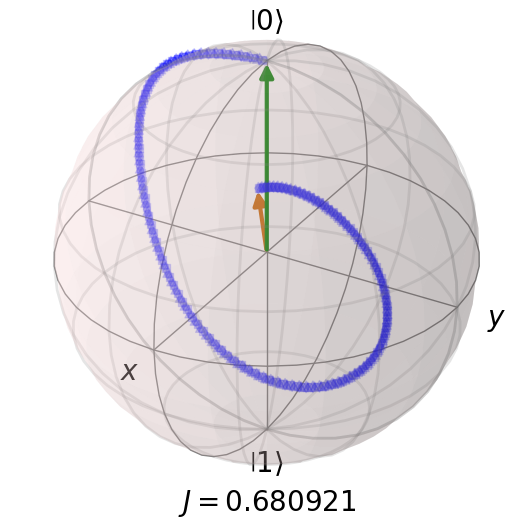

In [8]:
get_cost_function(np.pi, plot_bloch=True);


---

### **Running the optimization**

With the optimization dictionary and cost function correctly specified, we can now let QuOCS do the rest. The top-level interface in QuOCS is `Optimizer`, which contains

- The optimization algorithm of the user's choice to run the optimization.
- The communicator to output information as the optimization progresses.
- The exit handler which handles what happens when the optimization is interrupted (by the user or an error).

`Optimizer` is the only thing we need to construct after specifying the optimization dictionary and the cost function object, which makes `QuOCS` simple to use. We now run the optimization.

In [16]:
# Uncomment to conveniently turn off the long console messages.
# opt_dict["console_info"]=False

optimizer = Optimizer(opt_dict, MyCostFunction())
optimizer.execute();


---

### **Getting the QOC results**

The optimized pulse and its time list is stored inside the optimization algorithm object stored as the `opt_alg_obj` attribute of the `Optimizer` object. Alternatively, we can call the `get_optimization_algorithm` method to obtain the object.

In [47]:
optimizer.opt_alg_obj

In [48]:
optimizer.get_optimization_algorithm()

Here we retrieve the optimized control and its time list, as well as the change in the figure of merit (cost function in our case), then plot them.

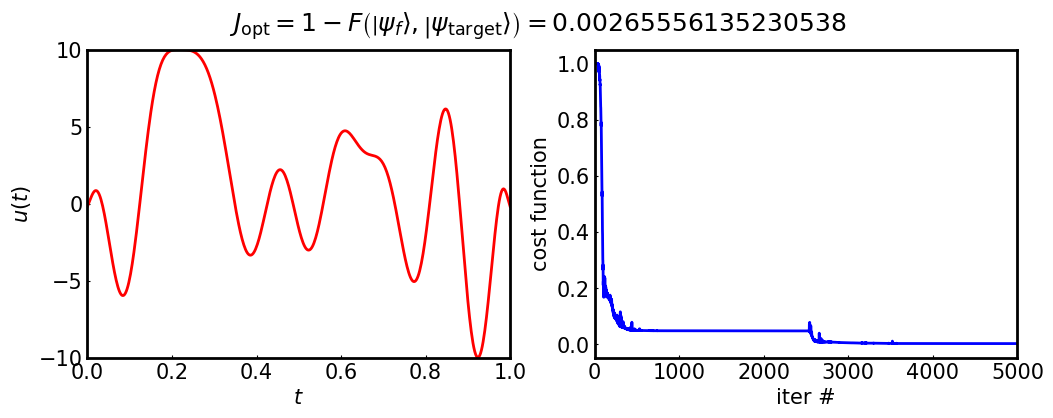

In [66]:
opt_alg = optimizer.get_optimization_algorithm()
tlist = opt_alg.get_best_controls()["timegrids"][0]
u_y_opt = opt_alg.get_best_controls()["pulses"][0]

cf_change = opt_alg.FoM_list

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs : typing.List[plt.Axes]

ax = axs[0]
ax.plot(tlist, u_y_opt, c = "r")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(opt_dict["pulses"][0]["lower_limit"],
            opt_dict["pulses"][0]["upper_limit"])
ax.set_ylabel(r"$u(t)$")
ax.set_xlabel(r"$t$")

ax = axs[1]
ax.plot(cf_change, c = "b")
ax.set_ylabel("cost function")
ax.set_xlabel("iter #")
ax.set_xlim(0, opt_alg.iteration_number)

fig.suptitle(r"$J_\mathrm{opt}=1-F\left(\left|\psi_f\right\rangle,\left|\psi_\mathrm{target}\right\rangle\right)=%s$" % opt_alg.best_FoM);

QuOCS automatically saves the important optimization data into the `QuOCS_Results` folder in the working directory. The data for each optimization run is saved into a folder inside `QuOCS_Results` whose name contains the date and time of the optimization run, as well as the optimization client name specified in the optimization dictionary (`"meow"` here by default). The folder contains:

- The optimized control value array saved into either `json` or `npz` format, depending on the dump format specified.
- The optimization dictionary saved as a `json` file.
- The optimized parameters (e.g. amplitude value for each basis function in dCRAB) into a `json` file. 
- The QuOCS version.

There does not seem to be any way to prevent this folder from being created in the current version, so we can delete it manually if we wish. Uncomment the following to conveniently delete the result folder.

In [15]:
# shutil.rmtree(os.path.join(os.getcwd(), "QuOCS_Results")) 


---

### **Performance of the optimized control**

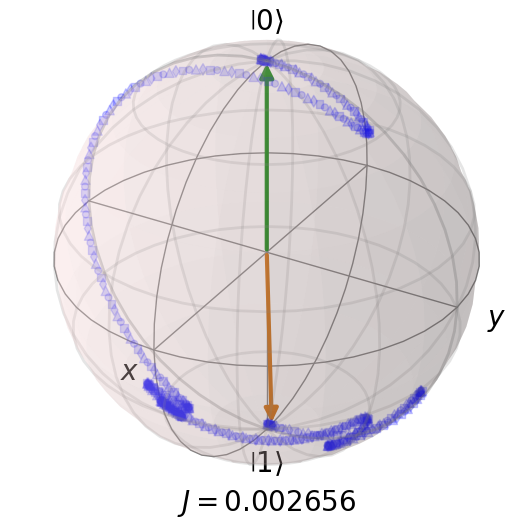

In [68]:
get_cost_function(u_y_opt, True);


---

### **Further reading**

- QuOCS' article: https://doi.org/10.1016/j.cpc.2023.108782 or https://arxiv.org/abs/2212.11144

- QuOCS' repository on GitHub: https://github.com/Quantum-OCS

- A review on QOC for NV center systems by Rembold et al.: https://doi.org/10.1116/5.0006785

- A great textbook on QOC theory by D'Alessandro: https://doi.org/10.1201/9781003051268